In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import allantools as at
from scipy.stats import norm

# Section 1 - Define functions to generate synthetic data

In [2]:
save_dir = '/eos/user/e/elsweene/SWAN_projects/Filtered_data_sets/'

In [3]:
## Load in CSF data

Truncated_Time_data = pd.read_csv(save_dir +'Complete_CSF_Data_filtered.csv')
filter2 = pd.read_csv(save_dir +"CSF_data_frame_filter2.csv",index_col=0)
CSF_frame = pd.read_csv(save_dir +"CSF_data_frame_unfiltered.csv",index_col=0)

In [4]:
## Filter frame data because tocsv doesn't save emptys

CSF_filter_frame =(CSF_frame[abs(CSF_frame['f0'])<.5e-12])

-5.535983752911291e-16


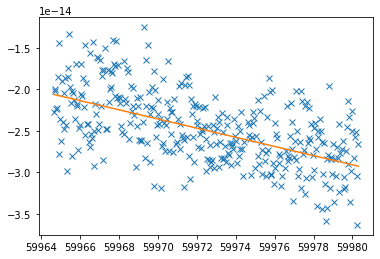

In [6]:
## Get rolling mean and fit line for linear drift

rolling_mean = np.array(Truncated_Time_data['f0'].rolling(window=24).mean().dropna())
shifted = np.array(Truncated_Time_data['f0'][:354]-rolling_mean[:354])
m_rm, b_rm = np.polyfit(Truncated_Time_data['TimeStamp'][:354],-1*rolling_mean[:354], 1)
print(m_rm)

plt.plot(Truncated_Time_data['TimeStamp'][:354],-1*Truncated_Time_data['f0'][:354],'x')
plt.plot(Truncated_Time_data['TimeStamp'][:354],m_rm*Truncated_Time_data['TimeStamp'][:354]+b_rm)

In [16]:
## Function of fitted linear drift line 

def mean_line(x,m,b):
    
    line = m*x+b
    return line

In [17]:
## Function for linear drift distribution

def linear_drift_dist(rm_range,linear_drift):

    list_differences = []

    for i in rm_range:

        x1 = linear_drift[i]
        x2 = linear_drift[i+1]

        diff = x1 - x2

        list_differences.append(diff)
    
    mu1, std1 = norm.fit(list_differences)
    
    return mu1,std1

In [18]:
## Function to add random walk drift to generated mean line data

def generate_random_walk(start_mean,start_sd,time_period,scalar,slope,constant):

    RW_Noise_data = []
    M= start_mean
    S = start_sd

    for i in time_period:
        #print(M)
        y_gen1 = mean_line(i,slope,constant)
        draw_noise = norm.rvs(loc=M,scale=(scalar*S),size=1)

        new_freq = y_gen1 + draw_noise

        RW_Noise_data.append(new_freq)

        M = draw_noise
        #print(M)
        
    Rand_walk_array = np.array(RW_Noise_data)
        
    return Rand_walk_array

In [19]:
## Define function to add white noise to generated data

def add_white_noise(index_array,RW_array,no_drift_array):    
    
    generated_freq = []
    mu, std = norm.fit(no_drift_array)

    for i in index_array:

        y_gen = RW_array[i]
        add_noise = norm.rvs(y_gen,scale= std,size=1)
        a = add_noise[0]

        generated_freq.append(a)
        
    return generated_freq

In [20]:
## Function to plot synthetic data beside original data

def plot_gen_data(time_frame,gen_freq):
    
    plot_original_data = plt.scatter(Truncated_Time_data['TimeStamp'][:875],-1*Truncated_Time_data['f0'][:875],color='g',label='CSF data')
    plot_fit_line = plt.plot(Truncated_Time_data['TimeStamp'], m_rm*np.array(Truncated_Time_data['TimeStamp']) + b_rm,'r')
    
    plot_linear_drift = plt.plot(Truncated_Time_data['TimeStamp'][:875],-1*rolling_mean[:875],'x')
    plot_generated_data = plt.plot(time_frame,gen_freq,'o',color='g')
    
    return plot_original_data, plot_fit_line,plot_linear_drift,plot_generated_data

In [21]:
## Function to save synthetic data to file 

def save_to(synthetic_data,time_frame,original_data):
    
    generated_data_freq = np.concatenate((original_data,synthetic_data))
    generated_data_time = np.concatenate((Truncated_Time_data['TimeStamp'][:875],time_frame))
    
    gen_data = {'Time': generated_data_time,
        'Generated FF': generated_data_freq }
  
    df_generated_CSF = pd.DataFrame(gen_data, columns=['Time', 'Generated FF'])
    
    return df_generated_CSF

# Section 2 - Generate regular set synthetic data

In [22]:
mean,stan_dev = linear_drift_dist(np.arange(0,874,1),-1*rolling_mean)
mean,stan_dev

(2.1912395118230354e-17, 1.8078259919953017e-16)

In [462]:
Ran_Walk_array = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),1,m_rm,b_rm)

In [463]:
Generated_data = add_white_noise(np.arange(0,7656,1),Ran_Walk_array,shifted)

(<matplotlib.collections.PathCollection at 0x7eff26933760>,
 [<matplotlib.lines.Line2D at 0x7eff26933c70>])

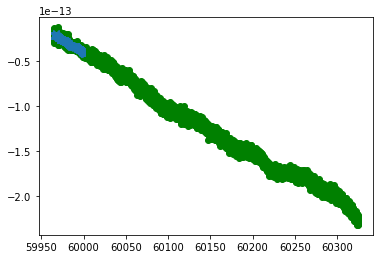

In [464]:
plot_gen_data(np.arange(60006,60325,1/24),Generated_data)

In [465]:
synthetic_data_regular = save_to(Generated_data,np.arange(60006,60325,1/24),-1*Truncated_Time_data['f0'][:875])

In [466]:
save_dir1 = '/eos/user/e/elsweene/SWAN_projects/Synthetic_Data/'

In [467]:
synthetic_data_regular.to_csv(save_dir1 + "generated_data_regular.csv", index=True)

# Section 3 - Synthetic Data with no Linear Drift

In [468]:
## Remove linear drift

linear_drift_array = -1*Truncated_Time_data['f0'][:875]
fitted_lin_drift = mean_line(Truncated_Time_data['TimeStamp'][:875],m_rm,b_rm)

no_linear_drift = linear_drift_array-fitted_lin_drift

In [469]:
## Fit line to data w linear drift removed

m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)

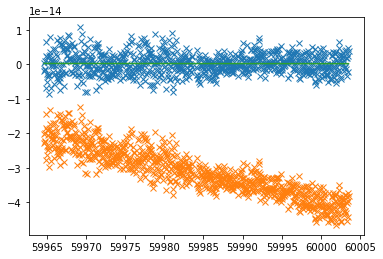

In [470]:
plt.plot(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,'x')
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_array,'x')

m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)
#print(m_no_LD)

plt.plot(Truncated_Time_data['TimeStamp'][:875],m_no_LD*Truncated_Time_data['TimeStamp'][:875]+b_no_LD)

In [534]:
mean_no_LD,stan_dev_no_LD = linear_drift_dist(np.arange(0,874,1),no_linear_drift)

In [538]:
mean_no_LD

-6.5948458201099276e-18

In [649]:
Ran_Walk_array_no_LD = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),1,m_no_LD,b_no_LD)

In [650]:
Generated_data_no_LD = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_no_LD,shifted)

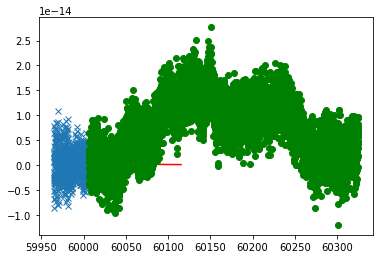

In [651]:
## Plot generated data

plt.plot(Truncated_Time_data['TimeStamp'], m_no_LD*np.array(Truncated_Time_data['TimeStamp']) + b_no_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_no_LD,'o',color='g')

In [690]:
synthetic_data_no_LD = save_to(Generated_data_no_LD,np.arange(60006,60325,1/24),no_linear_drift)

In [691]:
synthetic_data_no_LD.to_csv(save_dir1 + "generated_data_no_linear_drift.csv", index=True)

# Section 4 - Synthetic Data w no linear drift and 5x Random Walk

In [654]:
Ran_Walk_array_no_LD_5RW = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),5,m_no_LD,b_no_LD)

In [655]:
Generated_data_no_LD_5RW = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_no_LD_5RW,shifted)

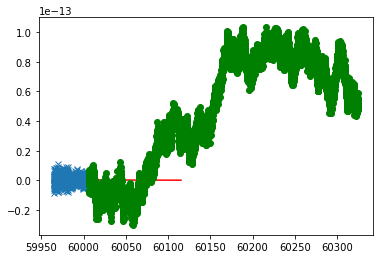

In [656]:
## Plot Generated Data

plt.plot(Truncated_Time_data['TimeStamp'], m_no_LD*np.array(Truncated_Time_data['TimeStamp']) + b_no_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_no_LD_5RW,'o',color='g')

In [692]:
synthetic_data_no_LD_5RW = save_to(Generated_data_no_LD_5RW,np.arange(60006,60325,1/24),no_linear_drift)

In [693]:
synthetic_data_no_LD_5RW.to_csv(save_dir1 + "generated_data_no_linear_drift_5x_Random_Walk.csv", index=True)

# Section 5 - Synthetic data with 5x Linear Drift

In [13]:
linear_drift_array = -1*Truncated_Time_data['f0'][:875]
fitted_5x_lin_drift = mean_line(Truncated_Time_data['TimeStamp'][:875],4*m_rm,((-4*m_rm*Truncated_Time_data['TimeStamp'][0])))

In [14]:
linear_drift_x5 = linear_drift_array+fitted_5x_lin_drift

In [15]:
m_5x_LD, b_5x_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],linear_drift_x5,1)

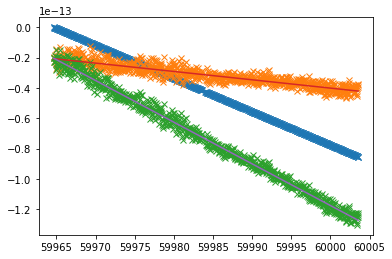

In [662]:
plt.plot(Truncated_Time_data['TimeStamp'][:875],fitted_5x_lin_drift,'x')
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_array,'x')
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_x5,'x')

# m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)
# #print(m_no_LD)

plt.plot(Truncated_Time_data['TimeStamp'][:875],m_rm*Truncated_Time_data['TimeStamp'][:875]+b_rm)
plt.plot(Truncated_Time_data['TimeStamp'][:875],m_5x_LD*Truncated_Time_data['TimeStamp'][:875]+b_5x_LD)

In [598]:
mean_5x,stan_dev_5x = linear_drift_dist(np.arange(0,874,1),linear_drift_x5)

In [663]:
Ran_Walk_array_5x_LD = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),1,m_5x_LD,b_5x_LD)

In [664]:
Generated_data_5x_LD = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_5x_LD,shifted)

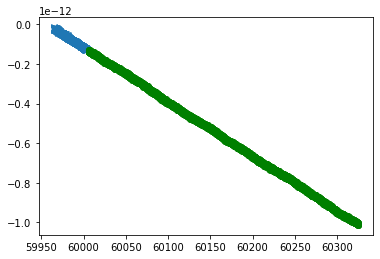

In [665]:
## Plot Generated Data

plt.plot(Truncated_Time_data['TimeStamp'], m_5x_LD*np.array(Truncated_Time_data['TimeStamp']) + b_5x_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_x5,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_5x_LD,'o',color='g')

In [694]:
synthetic_data_5x_LD = save_to(Generated_data_5x_LD,np.arange(60006,60325,1/24),linear_drift_x5)

In [695]:
synthetic_data_5x_LD.to_csv(save_dir1 + "generated_data_5x_linear_drift.csv", index=True)

# Section 6 - Synthetic data with 10x Linear Drift

In [17]:
linear_drift_array = -1*Truncated_Time_data['f0'][:875]
fitted_10x_lin_drift = mean_line(Truncated_Time_data['TimeStamp'][:875],9*m_rm,((-9*m_rm*Truncated_Time_data['TimeStamp'][0])))

In [18]:
linear_drift_x10 = linear_drift_array+fitted_10x_lin_drift

In [20]:
m_10x_LD, b_10x_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],linear_drift_x10,1)

In [21]:
print(m_10x_LD,b_10x_LD)

-5.497850024245985e-15 3.296562820859993e-10


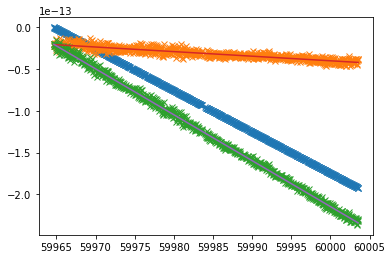

In [625]:
plt.plot(Truncated_Time_data['TimeStamp'][:875],fitted_10x_lin_drift,'x')
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_array,'x')
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_x10,'x')

# m_no_LD, b_no_LD = np.polyfit(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,1)
# #print(m_no_LD)

plt.plot(Truncated_Time_data['TimeStamp'][:875],m_rm*Truncated_Time_data['TimeStamp'][:875]+b_rm)
plt.plot(Truncated_Time_data['TimeStamp'][:875],m_10x_LD*Truncated_Time_data['TimeStamp'][:875]+b_10x_LD)

In [626]:
mean_10x,stan_dev_10x = linear_drift_dist(np.arange(0,874,1),linear_drift_x10)

In [668]:
Ran_Walk_array_10x_LD = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),1,m_10x_LD,b_10x_LD)

In [669]:
Generated_data_10x_LD = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_10x_LD,shifted)

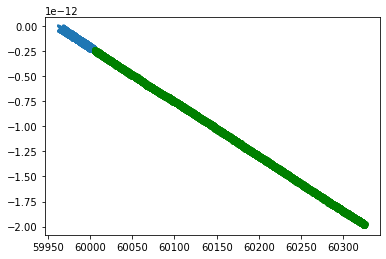

In [670]:
## Plot Generated Data

plt.plot(Truncated_Time_data['TimeStamp'], m_10x_LD*np.array(Truncated_Time_data['TimeStamp']) + b_10x_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_x10,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_10x_LD,'o',color='g')

In [696]:
synthetic_data_10x_LD = save_to(Generated_data_10x_LD,np.arange(60006,60325,1/24),linear_drift_x10)

In [697]:
synthetic_data_10x_LD.to_csv(save_dir1 + "generated_data_10x_linear_drift.csv", index=True)

# Section 7 - Synthetic data with 5x Linear Drift & 5x Random Walk

In [685]:
Ran_Walk_array_10x_LD_5x_RW = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),5,m_10x_LD,b_10x_LD)

In [686]:
Generated_data_10x_LD_5x_RW = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_10x_LD_5x_RW,shifted)

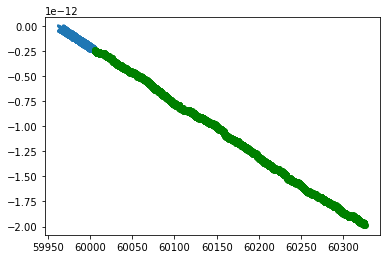

In [687]:
## Plot Generated Data

plt.plot(Truncated_Time_data['TimeStamp'], m_10x_LD*np.array(Truncated_Time_data['TimeStamp']) + b_10x_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],linear_drift_x10,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_10x_LD_5x_RW,'o',color='g')

In [698]:
synthetic_data_10x_LD_5x_RW = save_to(Generated_data_10x_LD_5x_RW,np.arange(60006,60325,1/24),linear_drift_x10)

In [699]:
synthetic_data_10x_LD_5x_RW.to_csv(save_dir1 + "generated_data_10x_5x_RW_linear_drift.csv", index=True)

# Section 8 - No LD 0.5 RW

In [700]:
Ran_Walk_array_no_LD_half_RW = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),0.5,m_no_LD,b_no_LD)

In [701]:
Generated_data_no_LD_half_RW = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_no_LD_half_RW,shifted)

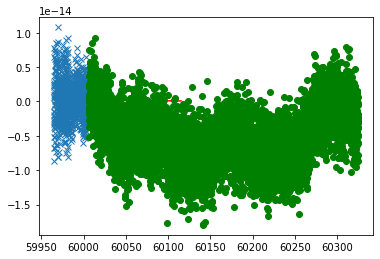

In [703]:
## Plot Generated Data

plt.plot(Truncated_Time_data['TimeStamp'], m_no_LD*np.array(Truncated_Time_data['TimeStamp']) + b_no_LD,'r')
    
plt.plot(Truncated_Time_data['TimeStamp'][:875],no_linear_drift,'x')
plt.plot(np.arange(60006,60325,1/24),Generated_data_no_LD_half_RW,'o',color='g')

In [704]:
synthetic_data_no_LD_half_RW = save_to(Generated_data_no_LD_half_RW,np.arange(60006,60325,1/24),no_linear_drift)

In [705]:
synthetic_data_no_LD_half_RW.to_csv(save_dir1 + "generated_data_no_linear_drift_half_Random_Walk.csv", index=True)

# Section 9 - Original LD , 0.5 RW

In [706]:
Ran_Walk_array_half_rw = generate_random_walk(mean,stan_dev,np.arange(60006,60325,1/24),0.5,m_rm,b_rm)

In [708]:
Generated_data_half_rw = add_white_noise(np.arange(0,7656,1),Ran_Walk_array_half_rw,shifted)

(<matplotlib.collections.PathCollection at 0x7eff24b0fbe0>,
 [<matplotlib.lines.Line2D at 0x7eff24b21160>])

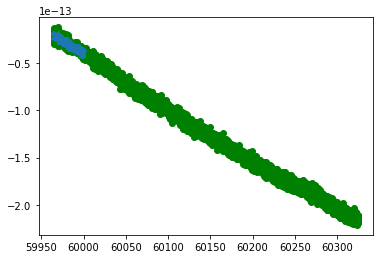

In [709]:
plot_gen_data(np.arange(60006,60325,1/24),Generated_data_half_rw)

In [710]:
synthetic_data_regular_w_half_rw = save_to(Generated_data_half_rw,np.arange(60006,60325,1/24),-1*Truncated_Time_data['f0'][:875])

In [711]:
synthetic_data_regular_w_half_rw.to_csv(save_dir1 + "generated_data_regular_w_half_rw.csv", index=True)